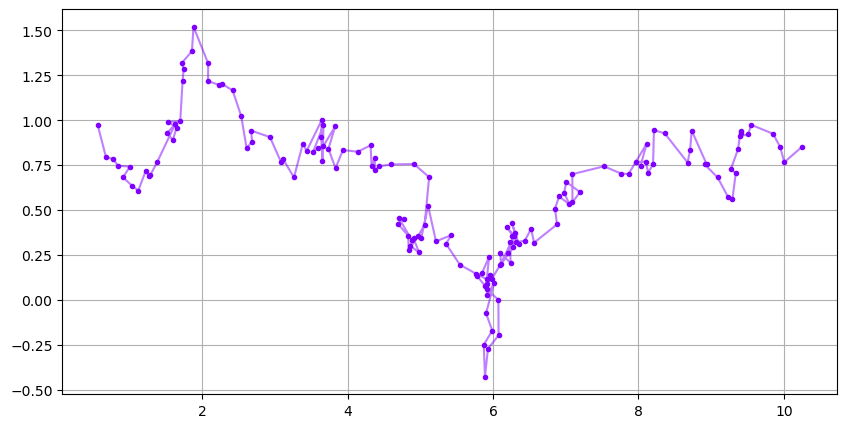

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy


class System:
    
    def __init__(self, curr_state = np.zeros((2,2))):
        self.alpha = 1e-3 #step size
        self.dim = curr_state.shape[0] #dimension of state space
        self.curr_state = curr_state
        self.dynamics_matrix = np.array([[1, 0.1],[0, 1]])
        self.observation_matrix = np.array([1, 0]) 
    
    #advance state according to dynamics, return next state and observation. Does not update internal state
    #uses state if given, otherwise uses internal state
    def F(self,state = None): 
        if not state:
            state = self.curr_state
        next_state = self.dynamics_matrix @ state + self.get_system_noise()
        observed_measurement = self.observation_matrix @ state + self.get_measurement_noise()
        return next_state, observed_measurement
        
    def get_measurement_noise(self,variance=0.1): 
      return np.random.normal(scale = variance)
    
    def get_system_noise(self,variance = 0.1):
      return np.random.normal(scale=variance, size=self.dim)
  
    def get_trajectories(self, initial_states):
        trajectories=[]    
        for x0 in initial_states:
            self.curr_state = x0
            trajectory = [x0]
            for _ in range(150):
                next_state, _ = system.F()
                trajectory.append(next_state)
                system.curr_state = next_state
            trajectory= np.array(trajectory)
            trajectories.append(trajectory)
        
        return trajectories
    


#only written for System, not to be used with later clases as general formatting
#of the classes changed
def plot_trajectories(system: System, initial_states: list):
    trajectories = system.get_trajectories(initial_states)
    colors = iter(plt.cm.rainbow(np.linspace(0, 0.5, len(initial_states))))
    plt.figure(figsize=[10,5])
    for xs, c in zip(trajectories, colors):
        plt.plot(xs[:,0], xs[:,1], '.', color=c)
        plt.plot(xs[:,0], xs[:,1], alpha=0.5, color=c)
    plt.grid()
    
    
x0 = np.random.uniform(size=2)
system = System()
plot_trajectories(system, [x0])

Question 1: 

We can take the jacobian of the dynamics function, and since the noise does not depend on the state, the stability argument is the same as always. So we just take the eigenvalues and look at their magnitudes.

The system is not observable. This can proved by either showing that the observable states are not an injection (technically since gaussian distribution can be anfiltered_yhing, the label could be literally anfiltered_yhing for any state) or that the labels are independent of the last state so it's also not an injection.

In [17]:


class StateEstimator:
  def __init__(self, F, H, s0):
    #Truths
    self.H = H
    self.F = F
    self.dim = s0.shape[0]
    self.I = 1
    self.st = s0
    self.P = np.linalg.pinv(H.T @ H)
  
    measurement_noise = self.get_measurement_noise()
    filtered_y=self.H @ self.st
    yt = filtered_y + measurement_noise
    s0_hat= self.P @ H.T @  yt


    self.filtered_y = filtered_y
    self.yt = yt
    self.prev_s_hat = s0_hat

    self.measurement_history=[yt]
    self.filtered_y_history=[filtered_y]
    self.state_history=[s0_hat]
    self.noise_history=[measurement_noise]
    self.L_history=[self.gain()]

    self.measurement_cov = [[.1]]
    self.system_cov = [[.1,0],[0,.1]] #indepdent so only diagonals are non-zero
    self.steady_P = scipy.linalg.solve_discrete_are(self.F.T, self.H.T, self.system_cov, self.measurement_cov)
    self.steady_L = self.steady_P @ self.H.T @ np.linalg.inv(self.measurement_cov + self.H @ self.P @ self.H.T)
    self.F_L = self.F - self.steady_L @ self.H @ self.F


    
    
  def get_measurement_noise(self,variance=0.3): 
    return np.random.normal(scale = variance)
    
  def get_system_noise(self,variance = 0.3):
    return np.random.normal(scale=variance, size=self.dim)
  
  #update internal matrix, return new state according to dynamics
  def extrapolate(self):
    extrap_s_hat = self.F @ self.prev_s_hat
    self.P = self.F @ self.P @ self.F + self.I
    return extrap_s_hat
    
  
  def gain(self):
    return self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.I) 
    
  #predict new state with kalman filter
  def predict_kalman(self):
    st_hat = self.extrapolate()
    L = self.gain()
    s_hat = st_hat + L @ (self.yt - self.H @ st_hat)
    return s_hat


  #predict new state with kalman filter
  def predict_steady_kalman(self):
    s_hat = self.F_L @ self.prev_s_hat + self.steady_L@self.yt
    return s_hat
    
  def predict_lls(self):
    t = len(self.measurement_history) 
    yt_vector = []
    #constructing measurement vector
    for yt in self.measurement_history:
      yt_vector.append(yt.item())
      for _ in range(self.dim):
        yt_vector.append(0)
    yt_vector = np.array(yt_vector[:-1 * self.dim]) #drop extra 0 vector appended to end by loop

    #constructing A
    A_n_rows = yt_vector.shape[0]
    A_n_columns = t * self.dim
    A = np.zeros((A_n_rows, A_n_columns))
    negative_I = -1 * np.eye(self.dim) #note that this identity matrix has different dimensions from the one used for gain

  
    A[0, 0:2] = self.H #base case
    for i in range(t-1):
        x_offset = self.dim * i
        y_offset = i*3 + 1 #3 because y has dim 1, state has dim 
        A[y_offset: y_offset + 2, x_offset: x_offset+2] = self.F
        A[y_offset: y_offset + 2, x_offset+2: x_offset+4] = negative_I
        A[y_offset+2, x_offset+2: x_offset+4]=self.H



    s_hats = np.linalg.pinv(A.T @ A) @ A.T @ yt_vector
    return s_hats[-2:]


  #1) storesz new true state and filtered measurement in object, does not make a new state prediction
  #2) updates all histories
  def update_system(self):
    system_noise = self.get_system_noise()
    measurement_noise = self.get_measurement_noise()

    self.st = self.F @ self.st + system_noise
    self.filtered_y = self.H @ self.st
    self.yt = self.filtered_y + measurement_noise
    
    self.noise_history.append(system_noise)
    self.noise_history.append(measurement_noise)
    self.state_history.append(self.st)
    self.measurement_history.append(self.yt)
    self.filtered_y_history.append(self.filtered_y)
    self.L_history.append(self.gain())
    
    

  # #returns observed state, measurement + true state, measurement
  # def system_vars(self): 
  #   return self.st, self.filtered_y, self.yt

  
  def get_trajectory(self, time_steps):
    s_hats, s_hats_steady, s_hats_lls =[],[],[]
    for _ in range(time_steps):
      s_hat = self.predict_kalman()
      s_hat_steady = self.predict_steady_kalman()
      s_hat_lls = self.predict_lls()
      s_hats_lls.append(s_hat_lls)
      s_hats.append(s_hat)
      s_hats_steady.append(s_hat_steady)
      self.update_system()
      self.prev_s_hat = s_hat

    return s_hats, s_hats_steady, s_hats_lls

    
  def get_trajectories(self, initial_states, time_steps):
    trajectories=[]    
    for x0 in initial_states:
        self.curr_state = x0
        sts, filtered_ys, s_hats, yts = self.get_trajectory_kalman(time_steps)
        trajectory = [sts, filtered_ys, s_hats, yts]
        trajectories.append(trajectory)
    
    return trajectories
  
  

#create 2 plots corresponding to st/s_hat, and y_t/yts.
def plot_trajectory(estimator: StateEstimator, trajectory):
  colors = iter(plt.cm.rainbow(np.linspace(0, 0.5, 4)))
  sts, filtered_ys, s_hats, yts = trajectory[0], trajectory[1], trajectory[2], trajectory[3]
  plt.figure(figsize=[10,5])
  

    #plotting states
  labels=["True states", "Estimated states"]
  for s, c, lab in zip([sts, s_hats], colors, labels):
    s=np.array(s)
    times = [i for i in range((len(s)))]     
    plt.plot(s[:,0], s[:,1], '.', color=c,)
    plt.plot(s[:,0], s[:,1],alpha=0.5, color=c,label=lab)
  plt.legend(loc="upper left")
  plt.xlabel('Position')
  plt.ylabel('Velocity')
  plt.grid()
  plt.show()
  labels = ["System outputs", "Filtered outputs"]
  #plotting measurements
  for y, c, lab in zip([filtered_ys, yts], colors, labels):
    times = [i for i in range((len(y)))]     
    plt.plot(times, y, '.', color=c,)
    plt.plot(times, y, alpha=0.5, color=c, label=lab)
  plt.legend(loc="upper left")
  plt.xlabel('Timestamp')
  plt.ylabel('Measurement')
  plt.grid()
  plt.show()
  



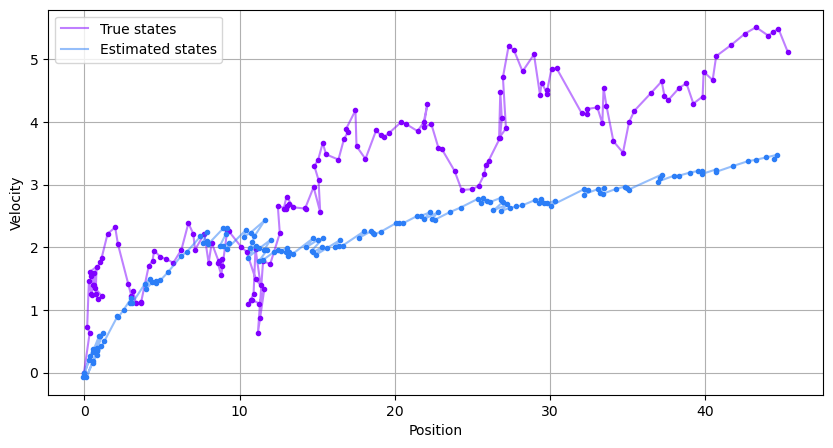

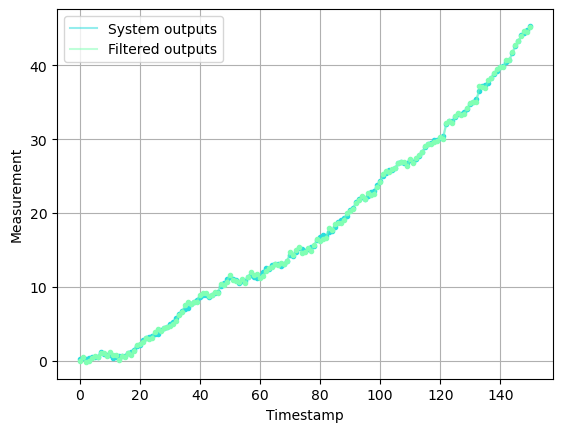

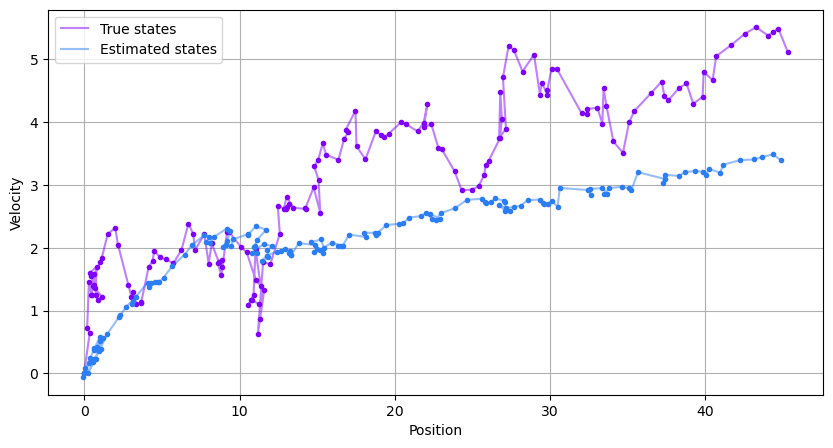

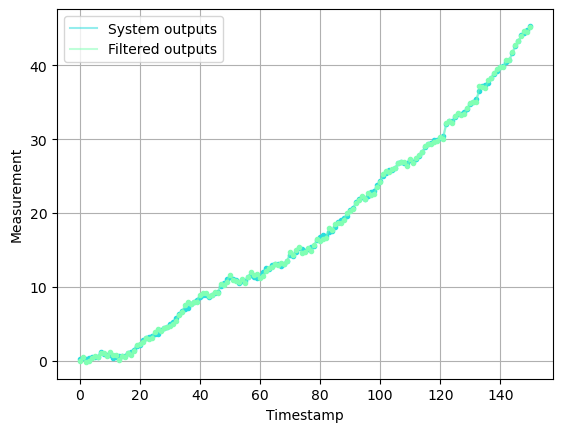

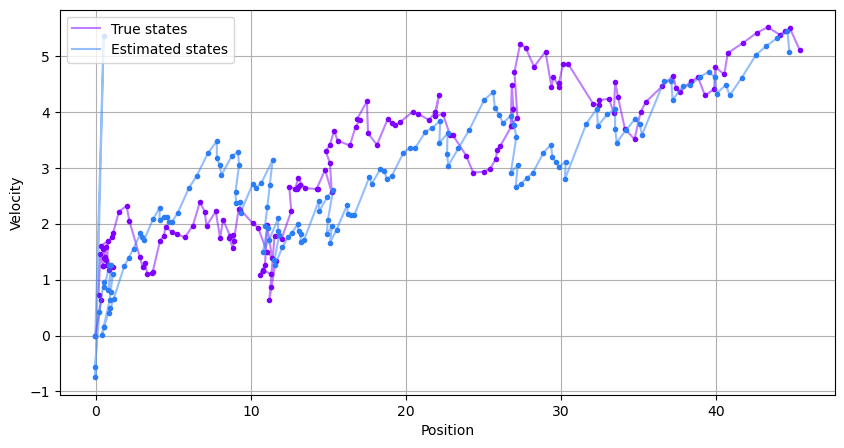

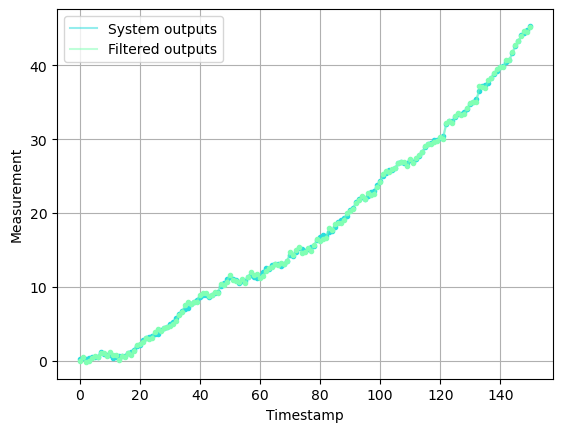

In [18]:
F = np.array([[1, 0.1],[0, 1]])
H = np.array([[1, 0]]) 
s0 = np.random.uniform(size=2)
estimator = StateEstimator(F, H, s0)
time_steps = 150
s_hats, s_hats_steady, s_hats_lls = estimator.get_trajectory(time_steps)

trajectory = estimator.state_history, estimator.filtered_y_history, s_hats, estimator.measurement_history
steady_trajectory = estimator.state_history, estimator.filtered_y_history, s_hats_steady, estimator.measurement_history
lls_trajectory = estimator.state_history, estimator.filtered_y_history, s_hats_lls, estimator.measurement_history



plot_trajectory(estimator, trajectory)
plot_trajectory(estimator, steady_trajectory)
plot_trajectory(estimator, lls_trajectory)




In [23]:
#question 4
del estimator
s0 = np.random.uniform(size=2)
estimator = StateEstimator(F, H, s0)
estimator.get_trajectory(time_steps)

m=10
yts = np.array(estimator.measurement_history)
X = np.zeros((time_steps-m, m)) #our labels are one-dimensional
Y = np.zeros((time_steps-m,1))
for t in range(time_steps-m):
    X[t] = yts[t: t+m, 0]
    Y[t] = yts[t+m]


theta = np.linalg.pinv(X.T @ X) @ X.T @ Y


In [27]:
del estimator
s0 = np.random.uniform(size=2)
estimator = StateEstimator(F, H, s0)
estimator.get_trajectory(time_steps)
yts = np.array(estimator.measurement_history)
X = np.zeros((time_steps-m, m)) #our labels are one-dimensional
for t in range(time_steps-m):
    X[t] = yts[t: t+m, 0]

predictions = X @ theta
yts=yts[10:]

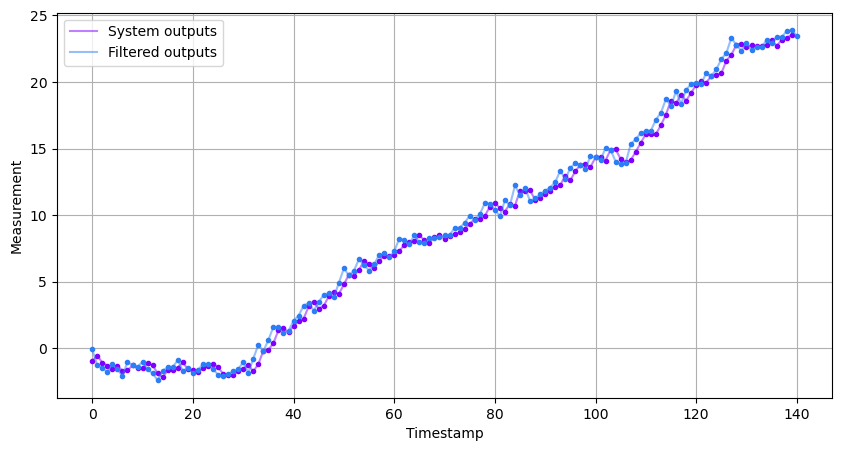

In [28]:
colors = iter(plt.cm.rainbow(np.linspace(0, 0.5, 4)))
plt.figure(figsize=[10,5])


labels = ["System outputs", "Filtered outputs"]
#plotting measurements
for y, c, lab in zip([predictions, yts], colors, labels):
    times = [i for i in range((len(y)))]     
    plt.plot(times, y, '.', color=c,)
    plt.plot(times, y, alpha=0.5, color=c, label=lab)
plt.legend(loc="upper left")
plt.xlabel('Timestamp')
plt.ylabel('Measurement')
plt.grid()
plt.show()
  